# Energy Expenditure

In [119]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn as sns

import Tracab as tracab
import Tracking_Visuals as vis
import Tracking_Velocities as vel
import helpers

import importlib
importlib.reload(tracab)
importlib.reload(helpers)
importlib.reload(vis)

<module 'Tracking_Visuals' from '/Users/jeffbalkanski/research_soccer/SoccerTrackingData3/Tracking_Visuals.py'>

In [2]:
# config
current_dir = os.path.dirname(os.getcwd())
fpath = os.path.join(current_dir, 'TrackingSample') # path to directory of Tracab data
LEAGUE = 'DSL'

## Data

In [3]:
# read frames, match meta data, and data for individual players
fname = '984628'
frames_tb, match_tb, team1_players, team0_players = tracab.read_tracab_match_data(LEAGUE, fpath, fname, verbose=True,
                                                                                    player_acceleration=False)

Reading match metadata
Reading match tracking data
Timestamping frames
Measuring velocities
home goalkeeper(s):  [1]
away goalkeeper(s):  [73]
0 67615
67616 139808


In [4]:
# pick a player
player = team0_players[5]

In [8]:
# metrics available
target_ex = player.frame_targets[10]
vars(target_ex)

{'team': 0,
 'sys_target_ID': 15,
 'jersey_num': 5,
 'pos_x': -1807.0,
 'pos_y': -673.0,
 'speed': 0.48,
 'ax': nan,
 'ay': nan,
 'a_magnitude': nan,
 'timestamp': 0.4,
 'vx': 0.821,
 'vy': -0.214,
 'speed_filter': 0.848}

# Acceleration

In [9]:
# COMPUTE acceleration
vel.estimate_player_accelerations(team1_players, team0_players, match_tb, window=5)

Warning, must get rid of accelerations that are too high > need to find a threshold


In [10]:
vars(player.frame_targets[10])

{'team': 0,
 'sys_target_ID': 15,
 'jersey_num': 5,
 'pos_x': -1807.0,
 'pos_y': -673.0,
 'speed': 0.48,
 'ax': 0.014,
 'ay': -0.004,
 'a_magnitude': 0.015,
 'timestamp': 0.4,
 'vx': 0.821,
 'vy': -0.214,
 'speed_filter': 0.848}

In [11]:
vars(team0_players[5].frame_targets[-2])

{'team': 0,
 'sys_target_ID': 26,
 'jersey_num': 5,
 'pos_x': 3147.0,
 'pos_y': 77.0,
 'speed': 0.86,
 'ax': 0.023,
 'ay': 0.013,
 'a_magnitude': 0.026,
 'timestamp': 2887.68,
 'vx': -0.107,
 'vy': -0.089,
 'speed_filter': 0.139}

In [12]:
# check 
player.frame_targets[3].a_magnitude

nan

In [19]:
# get all values to plot
velocities = helpers.get_all_values(player, 'speed_filter')
accelerations = helpers.get_all_values(player, 'ax')

print(len(velocities), velocities[:15])
print(len(accelerations), accelerations[:15])

139810 [  nan 0.305 0.346 0.42  0.511 0.555 0.644 0.724 0.769 0.836 0.848 0.883
 0.987 0.987 1.066]
139810 [  nan   nan   nan   nan   nan   nan 0.017 0.017 0.015 0.014 0.014 0.012
 0.014 0.012 0.012]


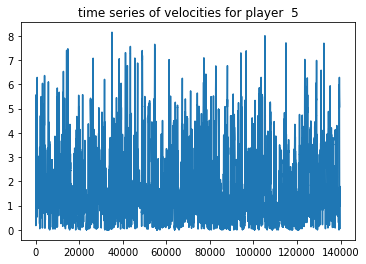

In [14]:
plt.plot(velocities)
plt.title('time series of velocities for player  {}'.format(player.jersey_num))
plt.show()

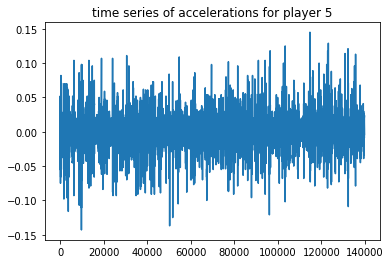

In [15]:
plt.plot(accelerations)
plt.title('time series of accelerations for player {}'.format(player.jersey_num))
plt.show()

# Energy expenditure calculation

We want to make make time series of energy expenditure for each player

1. **VeBVD =** sum of acceleration vectors
2. **metabolic power**  = 5th degree polynomial

In [20]:
import Tracking_Fatigue as fatigue

In [21]:
player.frame_targets[100].a_magnitude

0.037

## VeBDA - vector body acceleration
the VeDBA at time t, is `a_magnitude`. there is no a_magnitude on first frame!

For a possession starting at $s_n$ and ending at $e_n$ , the VeBDA for that posession is 
$$V'_n = \sum_{t=s_n}^{e_n}V_t$$

In [128]:
def estimate_player_VeBDA(team1_players, team0_players):
    """ estaimte player energy expenditure

    Keyword Arguments:
        metric {str} -- metric of energy expenditure (default: {'VeBDA'})
    """
    # get for all players
    all_players = list(team0_players.items()) + list(team1_players.items())
    for (num, player) in all_players:
        VeBDA = [sum([t.a_magnitude for t in player.frame_targets[:i]]) 
                    for i,frame in enumerate(player.frame_targets, 1)]
        player.VeBDA = VeBDA

In [129]:
# compute VeBDA
# estimate_player_VeBDA(team1_players, team0_players

In [130]:
# plot VeBDA
# VeBDA = helpers.get_all_values(player, 'VeBDA')
VeBDA = [sum([t.a_magnitude for t in player.frame_targets[:i]]) 
                for i,frame in enumerate(player.frame_targets, 1)]

KeyboardInterrupt: 

In [ ]:
plt.plot(VeBDA)
plt.show()

## Metabolic power
First must find the **energy cost**
$$EC =155.4i^5 −30.4i^4 −43.3i^3 +46.3i^2 +19.5i +3.6$$

In [176]:
# def estimate_metabolic_power(team1_players, team0_players, match, metric='metabolic'):
def estimate_metabolic_power(player, metric='metabolic'):
    # get accelerations
    ax = np.array([t.ax * 100 for t in player.frame_targets])
    ay = np.array([t.ay * 100 for t in player.frame_targets])
    vx = np.array([t.vx for t in player.frame_targets])
    vy = np.array([t.vy for t in player.frame_targets])
    
    # in m/s^2
    g = 9.81
    
    # find angle, of equivalent slope
    ix = np.tan(np.pi/2. - np.arctan(g/ax))
    iy = np.tan(np.pi/2. - np.arctan(g/ay)) 
    
    # find energy cost
    EC_x = 155.4*ix**5 - 30.4*ix**4 - 43.3*ix**3 + 46.3*ix**2 + 19.5*ix + 3.6
    EC_y = 155.4*iy**5 - 30.4*iy**4 - 43.3*iy**3 + 46.3*iy**2 + 19.5*iy + 3.6
    
    # equivalent mass ratio
    mx = np.sqrt((np.power(ax, 2)/g**2) + 1)
    my = np.sqrt((np.power(ay, 2)/g**2) + 1)
    
    # matabolic power
    Px = np.multiply(EC_x, mx, vx)
    Py = np.multiply(EC_y, my, vy)
    
    player.metabolic = Px + Py
    
    return Px + Py


In [196]:
# get accelerations
ax = np.array([t.ax * 100 for t in player.frame_targets])
ay = np.array([t.ay * 100 for t in player.frame_targets])
vx = np.array([t.vx for t in player.frame_targets])
vy = np.array([t.vy for t in player.frame_targets])

# in m/s^2
g = 9.81

# find angle, of equivalent slope
ix = np.tan(np.pi/2. - np.arctan(g/ax))
iy = np.tan(np.pi/2. - np.arctan(g/ay)) 

/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in arctan
  # This is added back by InteractiveShellApp.init_path()
/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in arctan
  if sys.path[0] == '':


In [205]:
np.nanmax(ix)

1.9979612640163102

In [204]:
iy[:30]

array([        nan,         nan,         nan,         nan,         nan,
               nan, -0.21406728, -0.14271152, -0.08154944, -0.07135576,
       -0.18348624, -0.16309888, -0.29561672, -0.3058104 , -0.3058104 ,
       -0.3058104 , -0.32619776, -0.18348624, -0.16309888, -0.14271152,
       -0.12232416, -0.13251784, -0.18348624, -0.2038736 , -0.27522936,
       -0.29561672, -0.27522936, -0.27522936, -0.3058104 , -0.23445464])

In [177]:
player_1_1 = team0_players[73]

In [194]:
ays = [t.ay for t in player.frame_targets]

In [195]:
np.nanmax(ays)

0.32

In [193]:
np.nanmax(as)

NameError: name 'ays' is not defined

In [178]:
metabolic = estimate_metabolic_power(player)

/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in arctan
  del sys.path[0]
/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in arctan
  


In [179]:
axs= [t.ax * 100 for t in player.frame_targets]

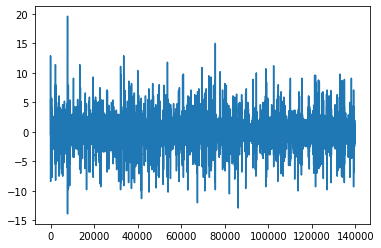

In [180]:
plt.plot(axs)

In [181]:
toplot = helpers.get_mean_every_k(metabolic, 1000)

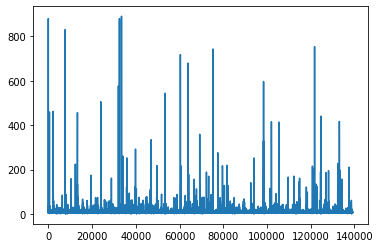

In [186]:
plt.plot(f)

plt.show()

In [185]:
f = metabolic[metabolic >=0]
f = f[abs(f) < 1000]

/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


# relating to physical performance

In [120]:
player = team0_players[11]

# get accelerations
accelerations = helpers.get_all_values(player, 'a_magnitude')

In [126]:
means = helpers.get_mean_every_k(accelerations, 4000)

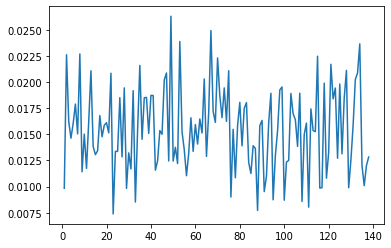

In [125]:
plt.plot(means)

In [127]:
player = team0_players[11]

# get accelerations
accelerations = helpers.get_all_values(player, 'VeBDA')

AttributeError: 'tracab_target' object has no attribute 'VeBDA'

In [ ]:
means = helpers.get_mean_every_k(accelerations, 4000)
plt.plot(means)